In [1]:
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import yaml
import pandas as pd
import mask_generator.settings as settings

In [9]:
EXPERIMENTS_DIR = "../experiments"

def load_yaml(path: str) -> dict:
    with open(path, "r") as f:
        return yaml.safe_load(f)

def load_run_yaml(run_path: str) -> dict:
    config_path = os.path.join(run_path, settings.config_filename)
    results_path = os.path.join(run_path, "results.yaml")

    if not os.path.exists(config_path) or not os.path.exists(results_path):
        return {}

    config = load_yaml(config_path)
    results = load_yaml(results_path)

    return {
        "config": config,
        "results": results
    }

def flatten_dict(d: dict, parent_key: str = '', sep: str = '.') -> dict:
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def load_experiments(experiments_dir: str = EXPERIMENTS_DIR) -> pd.DataFrame:
    run_dirs = [os.path.join(experiments_dir, d) for d in os.listdir(experiments_dir)
                if os.path.isdir(os.path.join(experiments_dir, d))]

    data = []
    for run_dir in run_dirs:
        run_data = load_run_yaml(run_dir)
        if not run_data:
            continue
        flat_config = flatten_dict(run_data["config"])
        flat_results = flatten_dict(run_data["results"])
        summary = {**flat_config, **flat_results}
        summary["run_dir"] = run_dir
        data.append(summary)

    df = pd.DataFrame(data)
    if df.empty:
        raise ValueError("No valid experiment data found.")
    df.reset_index(drop=True, inplace=True)
    return df

In [10]:
if not os.path.exists(EXPERIMENTS_DIR):
    raise FileNotFoundError(f"Experiments directory '{EXPERIMENTS_DIR}' does not exist.")
df = load_experiments(EXPERIMENTS_DIR)
print(f"df columns: {df.columns.tolist()}")

df.to_csv(os.path.join(EXPERIMENTS_DIR, "experiments_summary.csv"), index=False)

df columns: ['model.dropout', 'model.filters', 'model.n_convs', 'other.name', 'other.run_dir', 'other.run_hash', 'other.verbose', 'training.augmentations', 'training.batch_size', 'training.delta', 'training.eval_dataset_path', 'training.gamma', 'training.lr', 'training.num_epochs', 'training.patience', 'training.seed', 'training.step_size', 'training.train_dataset_path', 'training.train_image_size', 'training.use_amp', 'training.weighted_loss', 'best_epoch', 'test.conf_matrix', 'test.dice', 'test.iou', 'test.loss', 'time.formatted', 'time.seconds', 'total_epochs', 'run_dir', 'model.in_channels', 'model.out_channels', 'model.model_args.dropout', 'model.model_args.filters', 'model.model_args.n_convs']


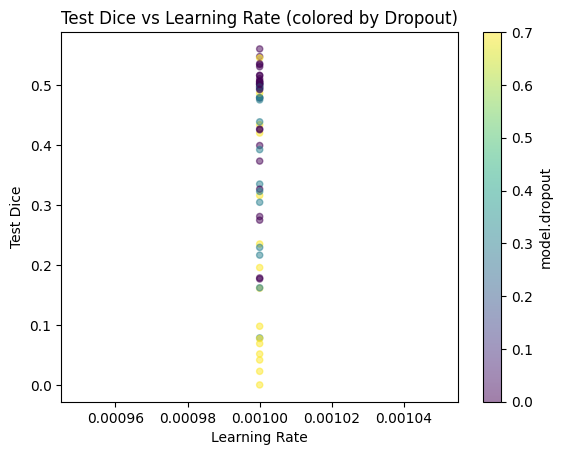

Top 5 runs by Test Dice:
                                      run_dir  test.dice
43  ../experiments/20250530_052145_c65426084f   0.571323
0   ../experiments/20250530_055109_98c02b2fc4   0.560955
22  ../experiments/20250529_234245_93bcfb303c   0.548197
26  ../experiments/20250531_020208_afa274c361   0.545966
55  ../experiments/20250529_230704_068c1381aa   0.536385


In [14]:
df1 = df.copy()
df1.plot.scatter(x="training.lr", y="test.dice", c="model.dropout", colormap="viridis", alpha=0.5)
plt.title("Test Dice vs Learning Rate (colored by Dropout)")
plt.xlabel("Learning Rate")
plt.ylabel("Test Dice")
plt.show()

df1['test.dice'].max()
print("Top 5 runs by Test Dice:")
print(df1.nlargest(5, 'test.dice')[['run_dir', 'test.dice']])

Top augmentations by max test.dice:


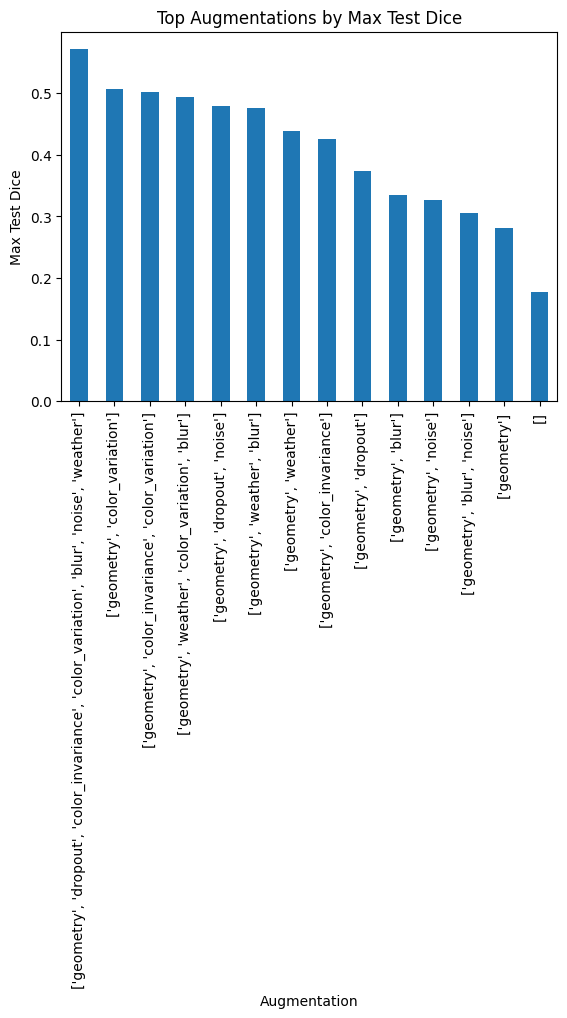

augment_str
['geometry', 'dropout', 'color_invariance', 'color_variation', 'blur', 'noise', 'weather']    0.571323
['geometry', 'color_variation']                                                               0.506237
['geometry', 'color_invariance', 'color_variation']                                           0.501950
['geometry', 'weather', 'color_variation', 'blur']                                            0.493002
['geometry', 'dropout', 'noise']                                                              0.478952
['geometry', 'weather', 'blur']                                                               0.475796
['geometry', 'weather']                                                                       0.439259
['geometry', 'color_invariance']                                                              0.425963
['geometry', 'dropout']                                                                       0.373711
['geometry', 'blur']                                         

In [12]:
df1["augment_str"] = df1["training.augmentations"].apply(lambda x: str(x) if isinstance(x, list) else x)
top_augments = df1.groupby("augment_str")["test.dice"].max().sort_values(ascending=False)
print("Top augmentations by max test.dice:")
top_augments.plot(kind='bar', title='Top Augmentations by Max Test Dice')
plt.xlabel("Augmentation")
plt.ylabel("Max Test Dice")
plt.show()

print(top_augments)

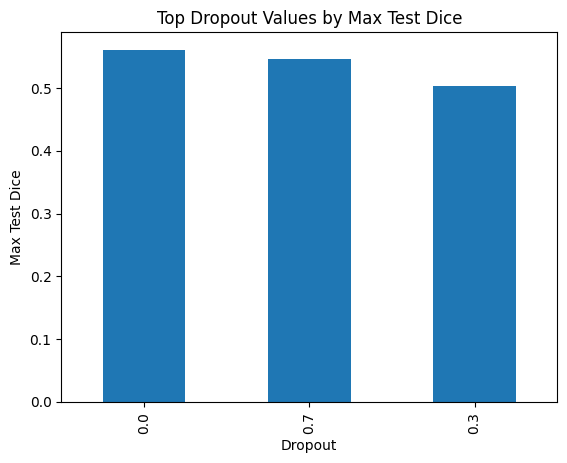

In [ ]:
top_dropout = df1.groupby("model.dropout")["test.dice"].max().sort_values(ascending=False)
top_dropout.plot(kind='bar', title='Top Dropout Values by Max Test Dice')
plt.xlabel("Dropout")
plt.ylabel("Max Test Dice")
plt.show()